In [3]:
import pandas as pd
import json
import numpy as np

CreateCSV = False
if CreateCSV:
    with open('probe_dataset\probe_labels.json', 'r') as f:
        data = json.load(f)

    #Merging all information in one simple dataframe pandas 
    annotations_df = pd.DataFrame(data['annotations'])
    images_df = pd.DataFrame(data['images'])
    merged_df = pd.merge(annotations_df, images_df, left_on='image_id', right_on='id')
    merged_df = merged_df.drop(columns=['id'])
    
    # To create a validation and a training set, I splitted it with a 90/10 ration 
    IsTrainValues = ["Train"] * (len(merged_df) - int(len(merged_df) * 0.1)) + ["Valid"] * int(len(merged_df) * 0.1)
    np.random.shuffle(IsTrainValues)
    merged_df["TrainningCategory"] = IsTrainValues
    merged_df.to_csv("DsFinetuned.csv",index=False)
    
else: 
    merged_df = pd.read_csv("Dataset/Images/DsFinetuned.csv")


In [4]:
merged_df.head(11)

,bbox,image_id,file_name,height,width,TrainningCategory
0,"[90.0, 0.0, 133.0, 208.0]",0,E300PREMP00002_00725_216_1flight_300_2.jpg,400,640,Train
1,"[90.0, 0.0, 133.0, 208.0]",1,E300PREMP00002_00725_216_1flight_900_2.jpg,400,640,Train
2,"[90.0, 0.0, 133.0, 208.0]",2,E300PREMP00002_00725_216_1flight_1500_2.jpg,400,640,Valid
3,"[90.0, 0.0, 133.0, 208.0]",3,E300PREMP00002_00725_216_1flight_2100_2.jpg,400,640,Train
4,"[90.0, 0.0, 133.0, 208.0]",4,E300PREMP00002_00725_216_1flight_2700_2.jpg,400,640,Train
5,"[90.0, 0.0, 133.0, 208.0]",5,E300PREMP00002_00725_216_1flight_3300_2.jpg,400,640,Train
6,"[90.0, 0.0, 133.0, 208.0]",6,E300PREMP00002_00725_216_1flight_3900_2.jpg,400,640,Valid
7,"[90.0, 0.0, 133.0, 208.0]",7,E300PREMP00002_00725_216_1flight_4500_2.jpg,400,640,Train
8,"[77.0, 0.0, 138.0, 247.0]",8,E300PREMP00002_00725_216_1flight_5100_2.jpg,400,640,Train
9,"[90.0, 0.0, 133.0, 208.0]",10,E300PREMP00002_00725_216_1flight_6300_2.jpg,400,640,Train


### Architecture creation
Using Yolo means to create the perfect architecture to match with what is needed.
I renamed and moved images for allowing the YOLO model to ork proprely


In [4]:
# Execute this only if you want to remake the archi
MakeArchi = False
if MakeArchi :
    import os
    import shutil
    SourceFolder = "probe_dataset\probe_images" 
    DestFolderTrain = "Dataset\Images\Train" 
    DestFolderValid = "Dataset\Images\Valid"

    for _, row in merged_df.iterrows():
        source_path = os.path.join(SourceFolder, row['file_name'])
        ImageID = row["image_id"]
        if row['TrainningCategory'] == "Train":
            DestPath = os.path.join(DestFolderTrain, f"image{ImageID}.jpg")
        else:
            DestPath = os.path.join(DestFolderValid, f"image{ImageID}.jpg")
        
        # Copy
        if os.path.exists(source_path):  # Check if file exist
            shutil.copy(source_path, DestPath)
            print(f"Copied {source_path} to {DestPath}")
        else:
            print(f"File not found: {source_path}")

Here I'm just showing the result using the image and the corresponding box, to see if it all work proprely

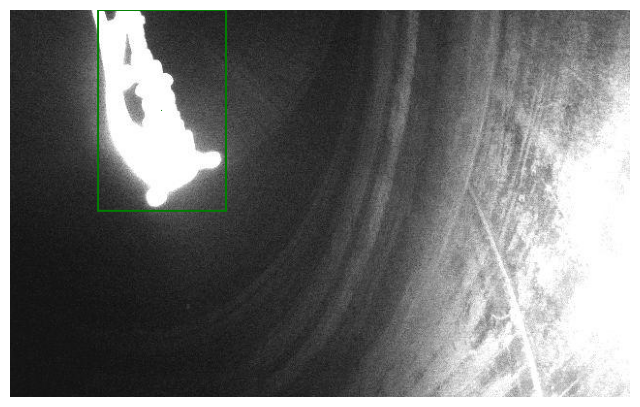

In [38]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import ast

image_folder = "probe_dataset\probe_images"
imageLine = merged_df.iloc[21]
imagepath = imageLine["file_name"]

image_path = f"{image_folder}/{imagepath}"
image = Image.open(image_path)

# Drawing box
draw = ImageDraw.Draw(image)
bbox = imageLine["bbox"]
bbox = ast.literal_eval(bbox)

x, y, width, height = bbox
xCenter = bbox[0] + width/2
yCenter = bbox[1] + height/2
draw.rectangle([x, y, x + width, y + height], outline="green", width=2)
draw.point([(xCenter,yCenter)], fill="green")

# Image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

### .txt Creation
To use the YOLO model, we need to attached with the iamge the information about the bounding box in a .txt next to the image.
This file need to be structured like this : 
ID-Class X Y Height Width

With X and Y the center of the bounding box
and all information Normalised with the image size.

In [34]:
CreateTxt = True
if CreateTxt:
    for _, row in merged_df.iterrows():
        name = "image" + str(row["image_id"])
        # Make a difference between trainning and validation set 
        if row["TrainningCategory"] == "Train":
            Folder = "Dataset/Images/Train"
        else:
            Folder = "Dataset/Images/Valid"
            
        # Create the file with all needed informations
        with open(f"{Folder}/{name}.txt", 'w') as file:
            bbox = ast.literal_eval(row["bbox"])
            xCenter = bbox[0] + bbox[2]/2
            yCenter = bbox[1] + bbox[3]/2
            
            xNormalised = xCenter/row["width"]
            yNormalised = yCenter/row["height"]
            hNormalised = bbox[2]/row["width"] 
            wNormalised = bbox[3]/row["height"]
            
            file.write(f"0 {xNormalised} {yNormalised} {hNormalised} {wNormalised}")